In [30]:
# Recommendation: `conda install --channel conda-forge geopandas`
import numpy as np
import math
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import shapely

In [52]:
def splits_to_regions_binary(row, splits):
    if splits is None:
        return 0
    if len(splits) == 0:
        return 0

    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num

In [3]:
pa_precincts = gpd.read_file('../data/pa/PA_2020_vtds/')
pa_precincts = pa_precincts.to_crs("EPSG:4269")
pa_precincts['GEOID20'] = pa_precincts['GEOID20'].astype(str)

print([x for x in pa_precincts.columns if "POP" in x])
print([x for x in pa_precincts.columns if x.startswith("G18GOV")])
print(pa_precincts.shape)
pa_precincts.sample(n=5)

['TOTPOP19', 'TOTPOP10', 'HPOP19', 'HPOP10', 'NHPOP19', 'NHPIPOP19', 'NHPOP10', '2MOREPOP19', '2MOREPOP10', 'ASIANPOP19', 'ASIANPOP10', 'AMINPOP19', 'AMINPOP10', 'BPOP19', 'BPOP10', 'NHPIPOP10', 'WPOP19', 'WPOP10']
['G18GOVRWAG', 'G18GOVDWOL', 'G18GOVGGLO', 'G18GOVLKRA']
(9178, 72)


,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,AMINPOP10,BCVAP19,BPOP19,BPOP10,NHPIPOP10,WPOP19,WCVAP19,WPOP10,CVAP19,geometry
7459,42101004710,4.0,112.0,PHILADELPHIA WARD 47 PRECINCT 10,0.0,004710,42,1.0,101,4.0,...,0.0,253.099047,302.038749,256.0,0.0,112.225000,86.645833,50.0,349.146213,"POLYGON ((-75.16773 39.97432, -75.16704 39.974..."
5080,42077001251,245.0,477.0,UPPER MACUNGIE DISTRICT 04,11.0,001251,42,9.0,077,259.0,...,12.0,193.608871,254.685484,99.0,0.0,1538.431806,977.246526,1137.0,1557.454209,"POLYGON ((-75.63844 40.54067, -75.63526 40.540..."
5896,42091002835,189.0,519.0,UPPER DUBLIN DISTRICT 04 DIVISION 03,4.0,002835,42,2.0,091,203.0,...,0.0,56.676022,55.539695,84.0,0.0,1073.209827,806.977707,1026.0,954.195050,"POLYGON ((-75.19649 40.14412, -75.19591 40.144..."
4142,42055000380,119.0,38.0,METAL DISTRICT 03,1.0,000380,42,2.0,055,121.0,...,1.0,0.000000,0.000000,1.0,0.0,363.888828,292.920981,437.0,293.327974,"POLYGON ((-77.83965 40.09752, -77.83895 40.098..."
4147,42055000440,38.0,18.0,ORRSTOWN,0.0,000440,42,0.0,055,40.0,...,0.0,1.500000,2.250000,6.0,0.0,267.217477,202.626411,254.0,208.922414,"POLYGON ((-77.61277 40.05765, -77.61145 40.058..."


In [4]:
pop = "TOTPOP19"
d_votes = "G18GOVDWOL"
r_votes = "G18GOVRWAG"

In [5]:
pa_precincts['REPRESENTATIVE_POINT'] =  pa_precincts.representative_point() # https://gis.stackexchange.com/a/414263
pa_precincts['RP_LON'] = pa_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
pa_precincts['RP_LAT'] = pa_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

print(pa_precincts.shape)
pa_precincts.sample(n=5)

(9178, 75)


,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,BPOP10,NHPIPOP10,WPOP19,WCVAP19,WPOP10,CVAP19,geometry,REPRESENTATIVE_POINT,RP_LON,RP_LAT
4949,42075000530,554.0,454.0,WEST CORNWALL,12.0,000530,42,2.0,075,590.0,...,15.0,0.0,1908.148760,1616.580579,1915.0,1690.625636,"POLYGON ((-76.47761 40.28666, -76.47224 40.288...",POINT (-76.45501 40.26281),-76.455010,40.262811
498,42003004630,116.0,356.0,MOUNT LEBANON WARD 04 DISTRICT 06,6.0,004630,42,2.0,003,129.0,...,7.0,0.0,1004.074925,754.349887,1053.0,790.956403,"POLYGON ((-80.03676 40.38434, -80.03597 40.384...",POINT (-80.03144 40.38048),-80.031436,40.380485
2706,42029000510,177.0,435.0,EASTTOWN DISTRICT 05,3.0,000510,42,2.0,029,190.0,...,19.0,0.0,1030.561343,770.543601,1056.0,867.719634,"POLYGON ((-75.44337 40.04742, -75.44317 40.047...",POINT (-75.43376 40.04105),-75.433763,40.041050
4462,42069000745,93.0,272.0,Dunmore Ward 06 District 04,0.0,000745,42,0.0,069,113.0,...,2.0,0.0,659.736343,471.501013,721.0,493.193837,"POLYGON ((-75.64316 41.42707, -75.64265 41.427...",POINT (-75.63853 41.42620),-75.638525,41.426201
2567,42027000170,105.0,61.0,CURTIN DISTRICT SOUTH,1.0,000170,42,2.0,027,105.0,...,4.0,0.0,415.928450,350.255537,514.0,355.161380,"POLYGON ((-77.79470 41.08143, -77.79083 41.082...",POINT (-77.72992 41.06396),-77.729923,41.063960


In [6]:
pa_precincts["Dem_Ratio"] = pa_precincts[d_votes]/(pa_precincts[d_votes] + pa_precincts[r_votes])
pa_precincts["Rep_Ratio"] = pa_precincts[r_votes]/(pa_precincts[d_votes] + pa_precincts[r_votes])
pa_precincts.sample(n=5)

,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,G18USSRBAR,...,WPOP19,WCVAP19,WPOP10,CVAP19,geometry,REPRESENTATIVE_POINT,RP_LON,RP_LAT,Dem_Ratio,Rep_Ratio
4051,42051000520,41.0,22.0,MARKLEYSBURG,1.0,000520,42,0.0,051,40.0,...,233.024848,193.141481,275.0,203.158416,"POLYGON ((-79.45693 39.72949, -79.45634 39.729...",POINT (-79.45186 39.73503),-79.451857,39.735032,0.349206,0.650794
9085,42133000630,1068.0,735.0,NEWBERRY DISTRICT 03,32.0,000630,42,14.0,133,1144.0,...,5132.371526,3892.006152,4410.0,4183.906044,"POLYGON ((-76.81940 40.16409, -76.81745 40.164...",POINT (-76.78667 40.15533),-76.786669,40.155326,0.434621,0.565379
7648,42101005509,49.0,132.0,PHILADELPHIA WARD 55 PRECINCT 09,0.0,005509,42,0.0,101,54.0,...,511.015184,419.446855,507.0,622.260870,"POLYGON ((-75.06372 40.03369, -75.06210 40.032...",POINT (-75.06123 40.03026),-75.061231,40.030265,0.736559,0.263441
7749,42101005812,141.0,177.0,PHILADELPHIA WARD 58 PRECINCT 12,0.0,005812,42,0.0,101,146.0,...,982.732155,630.650160,880.0,810.133530,"POLYGON ((-75.03038 40.11818, -75.03035 40.118...",POINT (-75.02821 40.11775),-75.028211,40.117753,0.562112,0.437888
2918,42033000050,119.0,49.0,BLOOM,1.0,000050,42,0.0,033,112.0,...,384.558473,312.147971,410.0,317.857820,"POLYGON ((-78.68380 41.00303, -78.68380 41.005...",POINT (-78.63881 41.02310),-78.638805,41.023101,0.269939,0.730061


In [18]:
# %%time
def split_this(df, n_districts, n_split=1, pop_col = "POPULATION", dem_col = "G18GOVD", rep_col = "G18GOVR", n_sample_angles=None):
    # print(n_districts)
    if n_districts != 1:
        # Get district ratios:
        if n_districts % 2 == 0:
            part_a = n_districts/2
            part_b = n_districts/2
        else:
            part_a = math.ceil(n_districts/2)
            part_b = math.floor(n_districts/2)

        # Get Total Population
        pop_total = df[pop_col].sum()

        # Get Population Center
        pop_center_LON = (df['RP_LON'] * df[pop_col]).sum()/pop_total
        pop_center_LAT =  (df['RP_LAT'] * df[pop_col]).sum()/pop_total

        # Re-center LAT/LON relative to the Population Center
        df['RECENTERED_LON'] = df['RP_LON'] - pop_center_LON
        df['RECENTERED_LAT'] = df['RP_LAT'] - pop_center_LAT

        # Get Angle by using ARCTAN(RECENTERED_LAT, RECENTERED_LON)
        df['RECENTERED_RATIO'] = df['RECENTERED_LAT']/df['RECENTERED_LON']
        df['RECENTERED_ANGLE'] = np.degrees(np.arctan2(df['RECENTERED_LAT'], df['RECENTERED_LON']))
        df['RECENTERED_ANGLE'] = df['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)


        ## LOOP for d in 0 to 359 ##
        start_angles = np.linspace(0,359,360)
        if n_sample_angles:
            start_angles = np.random.choice(start_angles, size=n_sample_angles)
        # Set Tracker for Angle Ranges and Competitiveness
        angle_ranges = []

        for d in start_angles:
            # Reset Angle to be Relative to d
            df['RESETTED_ANGLE'] = df['RECENTERED_ANGLE'] - d
            df['RESETTED_ANGLE'] = df['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x+360))
            df = df.sort_values('RESETTED_ANGLE').reset_index(drop=True)

            # Spin Clock Around till you achieve the desired ratio
            i = 0
            captured_pop = 0
            while captured_pop < (part_a)/(part_a+part_b)*pop_total:
                captured_pop += df.loc[i, pop_col]
                i += 1
            final_angle = df.loc[i-1, 'RECENTERED_ANGLE']

            ## Check if angle range loops past 360 for conditions:

            a1, a2 = d, final_angle
            if a1 < a2:
                df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
            elif a1 > a2:
                df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

            df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
            df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)

            # Calculate Entropy, want to maximize
            # TODO: Just calculate once and do 1-p for the other.
            summed_pops_a = df_a[[pop_col, dem_col, rep_col]].sum()
            entropy_a = entropy([(summed_pops_a[dem_col]/summed_pops_a[pop_col]), (summed_pops_a[rep_col]/summed_pops_a[pop_col])], base=2)

            summed_pops_b = df_b[[pop_col, dem_col, rep_col]].sum()
            entropy_b = entropy([(summed_pops_b[dem_col]/summed_pops_b[pop_col]), (summed_pops_b[rep_col]/summed_pops_b[pop_col])], base=2)

            angle_ranges.append({"start":d, "end":final_angle, "entropy_a":entropy_a, "entropy_b":entropy_b})


        ars = pd.DataFrame(angle_ranges)
        ars['entropy_prod'] = ars['entropy_a']*ars["entropy_b"]
        # ars = ars.sort_values("entropy_prod", ascending=False).reset_index(drop=True)
        ars = ars.sort_values("entropy_a", ascending=False).reset_index(drop=True)

        a1, a2 = ars.iloc[0]["start"], ars.iloc[0]["end"]
        ## Check if angle range loops past 360 for conditions:
        if a1 < a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
        elif a1 > a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

        df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
        df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)

        split_this(df_a, part_a, n_split=n_split+1, pop_col = pop_col, dem_col = dem_col, rep_col = rep_col, n_sample_angles=n_sample_angles)
        split_this(df_b, part_b, n_split=n_split+1, pop_col = pop_col, dem_col = dem_col, rep_col = rep_col, n_sample_angles=n_sample_angles)

        
    else:
        holder.append(df)

holder = []   
n_districts = 18
split_this(df=pa_precincts, n_districts=n_districts, pop_col=pop, dem_col=d_votes, rep_col=r_votes)

In [19]:
all_districts = pd.concat(holder).reset_index(drop=True)
split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

for c in split_columns:
    all_districts[c] = all_districts[c].fillna(0)

all_districts['DISTRICT'] = all_districts.apply(splits_to_regions_binary, splits=split_columns, axis=1)

In [20]:
all_districts['DISTRICT'].nunique()

18

In [21]:
# Shuffle for coloring
n_districts = all_districts['DISTRICT'].nunique()
random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
shuffle_dict = dict(zip(all_districts["DISTRICT"].unique(), random_districts))
all_districts["SHUFFLED"] = all_districts["DISTRICT"].apply(lambda x: shuffle_dict[x])

In [22]:
print(all_districts.groupby("SHUFFLED").sum()[pop].sum())
all_districts.groupby("SHUFFLED").sum()[pop]

12791530.0


SHUFFLED
0.0     712361.155707
1.0     710751.329999
2.0     712279.300266
3.0     711324.554484
4.0     709275.533994
5.0     708177.070595
6.0     710323.767132
7.0     708794.613008
8.0     710288.313291
9.0     709994.754811
10.0    711272.631043
11.0    710568.466483
12.0    711027.412416
13.0    708468.912381
14.0    708659.102690
15.0    712774.257936
16.0    711073.449316
17.0    714115.374450
Name: TOTPOP19, dtype: float64

<AxesSubplot:>

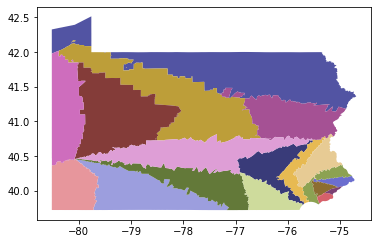

In [23]:
districts_df = all_districts.dissolve(by="SHUFFLED")
districts_df.plot(cmap="tab20b")

## Step by Step Review

In [69]:
def split_review(input_df, split, split_cols):
    input_df['TEMP_DISTRICT'] = input_df.apply(splits_to_regions_binary, splits=split_columns[:split], axis=1)
    n_districts = input_df['TEMP_DISTRICT'].nunique()
    # random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
    random_districts = np.linspace(0,n_districts-1,n_districts)
    shuffle_dict = dict(zip(input_df["TEMP_DISTRICT"].unique(), random_districts))
    input_df["TEMP_DISTRICT"] = input_df["TEMP_DISTRICT"].apply(lambda x: shuffle_dict[x])

    districts_df = input_df.dissolve(by = "TEMP_DISTRICT")
    base = districts_df.plot(cmap="tab20b")

    points = []
    for x in range(2**split):
        sub = input_df.loc[input_df['TEMP_DISTRICT'] == x]
        if sub.shape[0] == 0:
            continue
        pop_center_LON = (sub['RP_LON'] * sub[pop]).sum()/sub[pop].sum()
        pop_center_LAT =  (sub['RP_LAT'] * sub[pop]).sum()/sub[pop].sum()
        point = shapely.geometry.Point(pop_center_LON, pop_center_LAT)
        points.append(point)
    pop_center_df = gpd.GeoDataFrame(geometry=points)
    pop_center_df.plot(ax=base, color="white", linewidth=1.0, edgecolor="black")

    return districts_df


### Initial = 0

,geometry,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,...,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,SPLIT_3,SPLIT_4,SPLIT_5,DISTRICT,SHUFFLED
TEMP_DISTRICT,,,,,,,,,,,,,,,,,,,,,
0.0,"POLYGON ((-79.71899 39.72098, -79.71911 39.720...",42081000090,326.0,76.0,COGAN HOUSE,3.0,000090,42,4.0,081,...,-0.086961,175.029998,176.029998,1,1,1,1,1.0,31.0,15.0


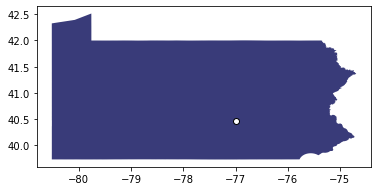

In [70]:
split_review(input_df=all_districts, split=0, split_cols=split_columns)

### Split = 1

,geometry,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,...,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,SPLIT_3,SPLIT_4,SPLIT_5,DISTRICT,SHUFFLED
TEMP_DISTRICT,,,,,,,,,,,,,,,,,,,,,
0.0,"POLYGON ((-76.74762 39.79012, -76.74768 39.790...",42081000090,326.0,76.0,COGAN HOUSE,3.0,000090,42,4.0,081,...,-0.086961,175.029998,176.029998,1,1,1,1,1.0,31.0,15.0
1.0,"POLYGON ((-75.75447 39.75563, -75.75468 39.755...",42071001802,414.0,219.0,WARWICK DISTRICT MILLPORT,9.0,001802,42,4.0,071,...,0.026567,1.521822,2.521822,0,1,1,1,1.0,15.0,0.0


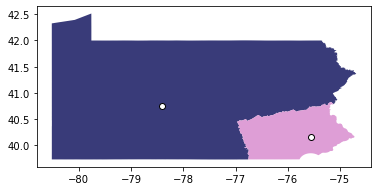

In [71]:
split_review(input_df=all_districts, split=1, split_cols=split_columns)

### Split = 2

,geometry,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,...,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,SPLIT_3,SPLIT_4,SPLIT_5,DISTRICT,SHUFFLED
TEMP_DISTRICT,,,,,,,,,,,,,,,,,,,,,
0.0,"MULTIPOLYGON (((-79.96556 40.47673, -79.96509 ...",42081000090,326.0,76.0,COGAN HOUSE,3.0,000090,42,4.0,081,...,-0.086961,175.029998,176.029998,1,1,1,1,1.0,31.0,15.0
1.0,"MULTIPOLYGON (((-76.77223 39.84166, -76.77206 ...",42041000202,401.0,421.0,EAST PENNSBORO DISTRICT 08,13.0,000202,42,5.0,041,...,-0.016935,359.029773,0.029773,1,0,1,1,0.0,22.0,17.0
2.0,"POLYGON ((-75.75447 39.75563, -75.75468 39.755...",42071001802,414.0,219.0,WARWICK DISTRICT MILLPORT,9.0,001802,42,4.0,071,...,0.026567,1.521822,2.521822,0,1,1,1,1.0,15.0,0.0
3.0,"POLYGON ((-75.35587 39.83888, -75.35653 39.838...",42101006311,208.0,369.0,PHILADELPHIA WARD 63 PRECINCT 11,2.0,006311,42,4.0,101,...,-0.016860,359.034065,0.034065,0,0,1,1,0.0,6.0,2.0


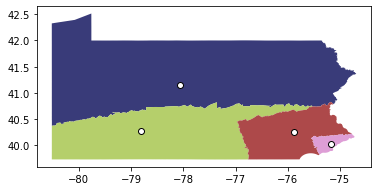

In [72]:
split_review(input_df=all_districts, split=2, split_cols=split_columns)

### Split = 3

,geometry,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,...,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,SPLIT_3,SPLIT_4,SPLIT_5,DISTRICT,SHUFFLED
TEMP_DISTRICT,,,,,,,,,,,,,,,,,,,,,
0.0,"MULTIPOLYGON (((-78.53812 40.74536, -78.53778 ...",42081000090,326.0,76.0,COGAN HOUSE,3.0,000090,42,4.0,081,...,-0.086961,175.029998,176.029998,1,1,1,1,1.0,31.0,15.0
1.0,"MULTIPOLYGON (((-79.96556 40.47673, -79.96509 ...",42121000320,143.0,72.0,MINERAL,2.0,000320,42,1.0,121,...,-8.132189,97.010361,98.010361,1,1,0,1,0.0,26.0,16.0
2.0,"MULTIPOLYGON (((-77.22894 39.82057, -77.22914 ...",42041000202,401.0,421.0,EAST PENNSBORO DISTRICT 08,13.0,000202,42,5.0,041,...,-0.016935,359.029773,0.029773,1,0,1,1,0.0,22.0,17.0
3.0,"POLYGON ((-77.34042 39.78753, -77.33965 39.787...",42129001580,184.0,119.0,MOUNT PLEASANT DISTRICT RIDGEVIEW,5.0,001580,42,2.0,129,...,-0.016235,359.069898,0.069898,1,0,0,1,0.0,18.0,3.0
4.0,"POLYGON ((-75.75447 39.75563, -75.75468 39.755...",42071001802,414.0,219.0,WARWICK DISTRICT MILLPORT,9.0,001802,42,4.0,071,...,0.026567,1.521822,2.521822,0,1,1,1,1.0,15.0,0.0
5.0,"POLYGON ((-75.39842 39.81047, -75.40321 39.807...",42017001790,601.0,852.0,NEW BRITAIN DISTRICT EAST,26.0,001790,42,9.0,017,...,0.201144,11.372932,12.372932,0,1,0,1,0.0,10.0,10.0
6.0,"POLYGON ((-75.44015 39.90873, -75.44014 39.908...",42101006311,208.0,369.0,PHILADELPHIA WARD 63 PRECINCT 11,2.0,006311,42,4.0,101,...,-0.016860,359.034065,0.034065,0,0,1,1,0.0,6.0,2.0
7.0,"POLYGON ((-75.35587 39.83888, -75.35653 39.838...",42101000603,19.0,468.0,PHILADELPHIA WARD 06 PRECINCT 03,2.0,000603,42,9.0,101,...,-0.085256,175.126959,176.126959,0,0,0,1,0.0,2.0,12.0


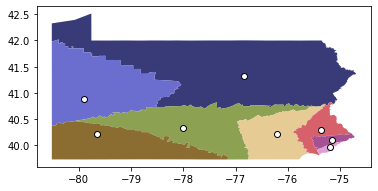

In [73]:
split_review(input_df=all_districts, split=3, split_cols=split_columns)

### Split = 4

,geometry,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,...,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,SPLIT_3,SPLIT_4,SPLIT_5,DISTRICT,SHUFFLED
TEMP_DISTRICT,,,,,,,,,,,,,,,,,,,,,
0.0,"MULTIPOLYGON (((-75.06429 40.88449, -75.06215 ...",42081000090,326.000000,76.000000,COGAN HOUSE,3.000000,000090,42,4.000000,081,...,-0.086961,175.029998,176.029998,1,1,1,1,1.0,31.0,15.0
1.0,"MULTIPOLYGON (((-78.53812 40.74536, -78.53778 ...",42049000410,71.000000,144.000000,ERIE WARD 04 DISTRICT 06,2.000000,000410,42,2.000000,049,...,-0.247390,166.104575,167.104575,1,1,1,0,0.0,28.0,8.0
2.0,"MULTIPOLYGON (((-80.51809 40.39857, -80.51807 ...",42121000320,143.000000,72.000000,MINERAL,2.000000,000320,42,1.000000,121,...,-8.132189,97.010361,98.010361,1,1,0,1,0.0,26.0,16.0
3.0,"MULTIPOLYGON (((-79.99755 40.47298, -80.00012 ...",42005000160,323.000000,146.000000,EAST FRANKLIN DISTRICT NORTHERN,4.000000,000160,42,1.000000,005,...,-0.017094,359.020660,0.020660,1,1,0,0,0.0,24.0,11.0
4.0,"MULTIPOLYGON (((-76.93763 40.23225, -76.93686 ...",42041000202,401.000000,421.000000,EAST PENNSBORO DISTRICT 08,13.000000,000202,42,5.000000,041,...,-0.016935,359.029773,0.029773,1,0,1,1,0.0,22.0,17.0
5.0,"MULTIPOLYGON (((-77.22894 39.82057, -77.22914 ...",4200300B920,16.000000,188.000000,PITTSBURGH WARD 21 DISTRICT 01,0.000000,00B920,42,1.000000,003,...,-0.067825,176.119859,177.119859,1,0,1,0,0.0,20.0,4.0
6.0,"POLYGON ((-77.34042 39.78753, -77.33965 39.787...",42129001580,184.000000,119.000000,MOUNT PLEASANT DISTRICT RIDGEVIEW,5.000000,001580,42,2.000000,129,...,-0.016235,359.069898,0.069898,1,0,0,1,0.0,18.0,3.0
7.0,"MULTIPOLYGON (((-79.72906 39.74622, -79.72791 ...",4200300D750,111.000000,193.000000,PITTSBURGH WARD 31 DISTRICT 04,1.000000,00D750,42,2.000000,003,...,-0.576013,150.057485,151.057485,1,0,0,0,0.0,16.0,13.0
8.0,"POLYGON ((-75.75447 39.75563, -75.75468 39.755...",42071001802,414.000000,219.000000,WARWICK DISTRICT MILLPORT,9.000000,001802,42,4.000000,071,...,0.026567,1.521822,2.521822,0,1,1,1,1.0,15.0,0.0


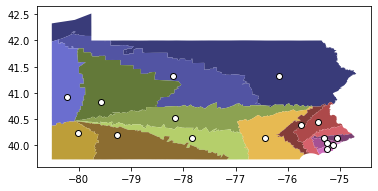

In [74]:
split_review(input_df=all_districts, split=4, split_cols=split_columns)

### Split = 5

,geometry,GEOID20,G18GOVRWAG,G18USSDCAS,NAME,G18USSLKER,VTDST,STATEFP,G18USSGGAL,COUNTYFP,...,RECENTERED_RATIO,RECENTERED_ANGLE,RESETTED_ANGLE,SPLIT_1,SPLIT_2,SPLIT_3,SPLIT_4,SPLIT_5,DISTRICT,SHUFFLED
TEMP_DISTRICT,,,,,,,,,,,,,,,,,,,,,
0.0,"MULTIPOLYGON (((-75.06429 40.88449, -75.06215 ...",42081000090,326.000000,76.000000,COGAN HOUSE,3.000000,000090,42,4.000000,081,...,-0.086961,175.029998,176.029998,1,1,1,1,1.0,31.0,15.0
1.0,"MULTIPOLYGON (((-75.28983 41.14607, -75.28981 ...",42079002595,380.739693,360.723830,WEST WYOMING WARD 01,3.609447,002595,42,2.609475,079,...,-0.013699,359.215174,0.215174,1,1,1,1,0.0,30.0,1.0
2.0,"MULTIPOLYGON (((-78.53812 40.74536, -78.53778 ...",42049000410,71.000000,144.000000,ERIE WARD 04 DISTRICT 06,2.000000,000410,42,2.000000,049,...,-0.247390,166.104575,167.104575,1,1,1,0,0.0,28.0,8.0
3.0,"MULTIPOLYGON (((-80.51809 40.39857, -80.51807 ...",42121000320,143.000000,72.000000,MINERAL,2.000000,000320,42,1.000000,121,...,-8.132189,97.010361,98.010361,1,1,0,1,0.0,26.0,16.0
4.0,"MULTIPOLYGON (((-79.99755 40.47298, -80.00012 ...",42005000160,323.000000,146.000000,EAST FRANKLIN DISTRICT NORTHERN,4.000000,000160,42,1.000000,005,...,-0.017094,359.020660,0.020660,1,1,0,0,0.0,24.0,11.0
5.0,"MULTIPOLYGON (((-76.93763 40.23225, -76.93686 ...",42041000202,401.000000,421.000000,EAST PENNSBORO DISTRICT 08,13.000000,000202,42,5.000000,041,...,-0.016935,359.029773,0.029773,1,0,1,1,0.0,22.0,17.0
6.0,"MULTIPOLYGON (((-77.22894 39.82057, -77.22914 ...",4200300B920,16.000000,188.000000,PITTSBURGH WARD 21 DISTRICT 01,0.000000,00B920,42,1.000000,003,...,-0.067825,176.119859,177.119859,1,0,1,0,0.0,20.0,4.0
7.0,"POLYGON ((-77.34042 39.78753, -77.33965 39.787...",42129001580,184.000000,119.000000,MOUNT PLEASANT DISTRICT RIDGEVIEW,5.000000,001580,42,2.000000,129,...,-0.016235,359.069898,0.069898,1,0,0,1,0.0,18.0,3.0
8.0,"MULTIPOLYGON (((-79.72906 39.74622, -79.72791 ...",4200300D750,111.000000,193.000000,PITTSBURGH WARD 31 DISTRICT 04,1.000000,00D750,42,2.000000,003,...,-0.576013,150.057485,151.057485,1,0,0,0,0.0,16.0,13.0


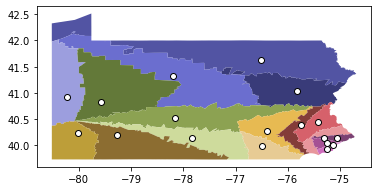

In [75]:
split_review(input_df=all_districts, split=5, split_cols=split_columns)